In [1]:
import numpy as np
import pandas as pd
from numpy import random

import matplotlib.pyplot as plt
from tqdm import tqdm

train_data_file = "./facebook_comment_volume/train.csv"
test_data_file = "./facebook_comment_volume/test.csv"

In [2]:
def train(x, y, lr=1e-4, max_iter=1000, batch_size=1024, shuffle=False, eps=1e-5):
    def iter_data(x, y):
        """
        Batchify dataset
        """
        if shuffle:
            rand_index = np.arange(len(x))
            np.random.shuffle(rand_index)
            x, y = x[rand_index], y[rand_index]
        for i in range(0, len(x), batch_size):
            span = slice(i, i + batch_size)
            yield x[span], y[span]
    
    def grad_func(x, y, theta):
        """
        Calculate gradient
        """
        n, p = len(y), len(theta)
        biased = np.ones((n, p))
        biased[:, 1:] = x
        y_ij = biased * theta
        y_pred = y_ij.sum(-1)
        mse = np.mean((y - y_pred) ** 2)
        grad = - 2 / n * (y - y_pred) @ biased
        return grad, mse

    y = y.reshape(-1)
    param_size = x.shape[1] + 1
    assert len(y) == x.shape[0], "Features and target sizes mismatch."
    
    # Initialize parameters
    theta = np.random.rand(param_size)
    
    prev_error = 1e100
    pbar = tqdm(range(max_iter), total=max_iter)
    batches = len(x) // batch_size + 1
    for _ in pbar:
        cum_loss = 0
        for x_batch, y_batch in iter_data(x, y):
            # Gradient descend
            grad, error = grad_func(x_batch, y_batch, theta)
            theta = theta - lr * grad
            if np.linalg.norm(grad) < eps:
                break
            prev_error = error
            cum_loss += error
        pbar.set_description(f"Loss: {cum_loss/batches:.4f}")
    return theta

In [3]:
def prediction(x, theta):
    n, p = len(x), len(theta)
    assert (n, p - 1) == x.shape, f"Data and parameters sizes mismatch."
    
    biased = np.ones((n, p))
    biased[:, 1:] = x
    return biased @ theta

In [4]:
def metrics(y, y_pred):
    mse = np.mean((y - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - mse / np.var(y)
    return rmse, r2

def linear_normalization(train, *args):
    t_min = train.min(axis=0, keepdims=True)
    t_max = train.max(axis=0, keepdims=True)
    t_s = (t_max - t_min)
    t_s[t_s == 0] = 1
    return tuple((part - t_min) / t_s for part in [train, *args])

def standard_score_normalization(train, *args):
    mean = train.mean(axis=0, keepdims=True)
    std = train.std(axis=0, keepdims=True)
    std[std == 0] = 1
    return tuple((part-mean)/std for part in [train, *args])
    

In [5]:
def plot_2d(x, y, a, b):
    x = x.reshape(-1)
    y = y.reshape(-1)

    plt.scatter(x, y)
    plt.plot(x, b * x + a, c="r")

### Train model on dummy dataset

Loss: 0.0000: 100%|██████████| 1000/1000 [00:01<00:00, 583.25it/s]


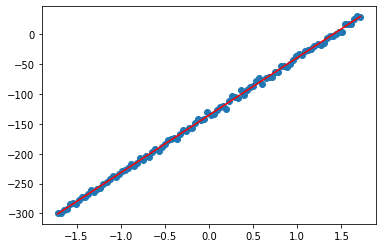

In [6]:
n_samples = 100
x = np.linspace(-100, 10, n_samples).reshape(-1, 1)
weights = np.array([3.])
y = x @ weights + 3 * np.random.randn(n_samples)
x, = linear_normalization(x)
x, = standard_score_normalization(x)

theta = train(x, y, 1e-1)
a, b = theta

plot_2d(x, y, a, b)

In [7]:
def kfold(x, k=5, shuffle=True):
    index = np.arange(len(x))
    if shuffle:
        random.shuffle(index)
    chunks = np.array_split(index, k)
    for i in range(k):
        train_index = np.concatenate(tuple(ch for j, ch in enumerate(chunks) if j != i))
        test_index = chunks[i]
        yield train_index, test_index

### Train model with 5 folds on Facebook Comment Volume dataset

In [9]:
df = pd.read_csv(train_data_file, header=None)
x = df.values[:,:-1]
y = df.values[:,-1]

metric_log = []

for i, (train_idx, test_idx) in enumerate(kfold(x)):
    train_x, train_y = x[train_idx], y[train_idx]
    test_x, test_y = x[test_idx], y[test_idx]
    
    train_x, test_x = standard_score_normalization(train_x, test_x)
    
    # Train model and make predictions for Train and Test parts.
    theta = train(train_x, train_y, lr=0.001, shuffle=True)
    train_pred_y = prediction(train_x, theta)
    pred_y = prediction(test_x, theta)
    
    # Calculate metrics for Train and Test predictions.
    train_rmse, train_r2 = metrics(train_y, train_pred_y)
    rmse, r2 = metrics(test_y, pred_y)
    
    metric_log.append([train_rmse, rmse, train_r2, r2])

mean = np.mean(metric_log, axis=0)
std = np.std(metric_log, axis=0)

df = pd.DataFrame(np.array(metric_log + [mean] + [std]),
                  columns=["Train RMSE", "Test RMSE", "Train R2", "Test R2"],
                  index=[f"Fold {i+1}" for i in range(len(metric_log))] + ["Mean"] + ["Std"])
df

Loss: 851.4017: 100%|██████████| 1000/1000 [00:28<00:00, 34.58it/s]


,Train RMSE,Test RMSE,Train R2,Test R2
Fold 1,28.562181,32.576515,0.339109,0.220595
Fold 2,29.591816,27.797624,0.319863,0.327577
Fold 3,29.289406,29.457174,0.320850,0.303878
Fold 4,29.336425,28.848038,0.325438,0.304073
Fold 5,29.169444,29.531302,0.312874,0.352072
Mean,29.189854,29.642131,0.323627,0.301639
Std,0.342741,1.593103,0.008723,0.044261
